# Pneumonia Detection via ResNet50

### 1. Imports & Drive Mount

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import collections

import tensorflow as tf
from tensorflow import keras
from keras import layers
import sklearn.metrics as sk_metrics

import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### 2. Configuration

In [2]:
DATASET_PATH = "/content/drive/MyDrive/computer vision course/projects/Chest X-Ray Images (Pneumonia)/Dataset"
IMG_SIZE     = (224, 224)
BATCH_SIZE   = 32
SEED         = 42

### 3. Dataset Loading & Splitting

In [18]:
Train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    color_mode="rgb"
)

class_names = Train_dataset.class_names
print("Classes:", class_names)  # ['NORMAL', 'PNEUMONIA']

val_test_dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,   # Changed to True to ensure mixed classes in val/test split
    color_mode="rgb"
)

val_batches       = int(len(val_test_dataset) * (3/4))
validation_dataset = val_test_dataset.take(val_batches)
Testing_dataset     = val_test_dataset.skip(val_batches)

AUTOTUNE = tf.data.AUTOTUNE
Train_dataset      = Train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
Testing_dataset    = Testing_dataset.prefetch(buffer_size=AUTOTUNE)

print(f"Train batches:      {len(Train_dataset)}")
print(f"Validation batches: {len(validation_dataset)}")
print(f"Test batches:       {len(Testing_dataset)}")

Found 5856 files belonging to 2 classes.
Using 4685 files for training.
Classes: ['NORMAL', 'PNEUMONIA']
Found 5856 files belonging to 2 classes.
Using 1171 files for validation.
Train batches:      147
Validation batches: 27
Test batches:       10


### 4. Handle Class Imbalance via Class Weights

In [19]:
def get_class_weights(dataset):
    class_counts = collections.defaultdict(int)
    for _, labels in dataset.unbatch():
        class_counts[int(labels.numpy())] += 1
    total = sum(class_counts.values())
    n_cls = len(class_counts)
    weights = {cls: total / (n_cls * cnt) for cls, cnt in class_counts.items()}
    return weights

class_weights = get_class_weights(Train_dataset)
print("Class Names   :", class_names)
print("Class Counts  :", dict(collections.Counter(
    int(l) for _, labels in Train_dataset.unbatch() for l in [labels])))
print("Class Weights :", class_weights)
# مثال: {0: 2.3, 1: 0.7} — بيدي وزن أكبر لـ NORMAL لأنها أقل

Class Names   : ['NORMAL', 'PNEUMONIA']
Class Counts  : {1: 3385, 0: 1300}
Class Weights : {1: 0.6920236336779911, 0: 1.801923076923077}


### 5. Data Augmentation

In [20]:
# للـ Chest X-Ray: لا vertical flip، rotation صغيرة، brightness مهم
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),       # horizontal فقط — X-rays مش بتتقلب vertical
    layers.RandomRotation(0.05),           # ± 5% فقط — مش أكتر في الطبي
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1),          # مهم لـ X-rays لأن exposure بيختلف
    layers.RandomContrast(0.15),
], name="data_augmentation")

### 6. Model Architecture

In [21]:
base_model = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False


# ✅ Functional API بدل Sequential — أوضح وأسهل في الـ Grad-CAM
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)  # Binary: 0=Normal, 1=Pneumonia

model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer_4[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 224, 224,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 224, 224,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_1[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048)      │      8,192 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    524,544 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        257 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,120,705 (92.01 MB)

 Trainable params: 528,897 (2.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

### 7. Phase 1 : Feature Extraction (Base Frozen)

In [22]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.AUC(name="auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall")
    ]
)

# ✅ monitor=val_recall لأن في الطب الـ False Negative (فاتنا pneumonia) أخطر من الـ False Positive
callbacks_phase1 = [
    keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True,
        monitor='val_auc',
        mode='max'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_auc',
        mode='max',
        patience=3,
        factor=0.3
    ),
    keras.callbacks.ModelCheckpoint(
        "best_model_phase1.keras",
        save_best_only=True,
        monitor='val_auc',
        mode='max'
    )
]

history1 = model.fit(
    Train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    class_weight=class_weights,  # ✅ مفعّل دلوقتي!
    callbacks=callbacks_phase1
)

Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.8894 - auc: 0.9427 - loss: 0.3626 - precision: 0.9545 - recall: 0.8881 - val_accuracy: 0.8900 - val_auc: 0.9816 - val_loss: 0.2677 - val_precision: 0.9878 - val_recall: 0.8659 - learning_rate: 0.0010
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 84s 569ms/step - accuracy: 0.9286 - auc: 0.9807 - loss: 0.1925 - precision: 0.9729 - recall: 0.9263 - val_accuracy: 0.8877 - val_auc: 0.9772 - val_loss: 0.3286 - val_precision: 0.9878 - val_recall: 0.8632 - learning_rate: 0.0010
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 84s 575ms/step - accuracy: 0.9400 - auc: 0.9831 - loss: 0.1733 - precision: 0.9746 - recall: 0.9402 - val_accuracy: 0.9097 - val_auc: 0.9752 - val_loss: 0.3417 - val_precision: 0.9867 - val_recall: 0.8943 - learning_rate: 0.0010
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 75s 515ms/step - accuracy: 0.9464 - auc: 0.9889 - loss: 0.1336 - precision: 0.9842 - recall: 0.9406 - val_accuracy: 0.9120 - val_auc: 0.9821 - val_loss: 0.

### 8. Phase 2 : Fine Tuning (unfreeze Last Layers)

In [23]:
# ✅ Unfreeze آخر 20 layer فقط (أكثر تحفظاً من 30)
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

trainable_count = sum(1 for l in base_model.layers if l.trainable)
print(f"Trainable layers in base_model: {trainable_count}")

# ✅ LR أصغر بكتير للـ fine-tuning
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.AUC(name="auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall")
    ]
)

callbacks_phase2 = [
    keras.callbacks.EarlyStopping(
        patience=7,
        restore_best_weights=True,
        monitor='val_auc',
        mode='max'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_auc',
        mode='max',
        patience=4,
        factor=0.5
    ),
    keras.callbacks.ModelCheckpoint(
        "best_model_final.keras",
        save_best_only=True,
        monitor='val_auc',
        mode='max'
    )
]

history2 = model.fit(
    Train_dataset,
    validation_data=validation_dataset,
    epochs=30,
    class_weight=class_weights,  # ✅
    callbacks=callbacks_phase2
)

Trainable layers in base_model: 20
Epoch 1/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 77s 432ms/step - accuracy: 0.9411 - auc: 0.9874 - loss: 0.1433 - precision: 0.9808 - recall: 0.9365 - val_accuracy: 0.9178 - val_auc: 0.9842 - val_loss: 0.2449 - val_precision: 0.9868 - val_recall: 0.9044 - learning_rate: 1.0000e-05
Epoch 2/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 58s 397ms/step - accuracy: 0.9563 - auc: 0.9907 - loss: 0.1158 - precision: 0.9832 - recall: 0.9555 - val_accuracy: 0.9144 - val_auc: 0.9815 - val_loss: 0.2640 - val_precision: 0.9864 - val_recall: 0.8980 - learning_rate: 1.0000e-05
Epoch 3/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 59s 399ms/step - accuracy: 0.9582 - auc: 0.9938 - loss: 0.1000 - precision: 0.9870 - recall: 0.9542 - val_accuracy: 0.9132 - val_auc: 0.9829 - val_loss: 0.2596 - val_precision: 0.9898 - val_recall: 0.8940 - learning_rate: 1.0000e-05
Epoch 4/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 60s 407ms/step - accuracy: 0.9626 - auc: 0.9939 - loss: 0.0949 - precision: 0.9892 - recall: 0.9580 - val_

### 9. Training History Visualization

In [38]:
def plot_history(history, title):
    fig = make_subplots(rows=1, cols=3, subplot_titles=('Loss', 'AUC', 'Accuracy'))
    for col, (metric, val_metric) in enumerate([('loss','val_loss'),('auc','val_auc'), ('accuracy','val_accuracy')], 1):
        fig.add_trace(go.Scatter(y=history.history[metric],      name='Train', marker_color='blue',  mode='lines'), row=1, col=col)
        fig.add_trace(go.Scatter(y=history.history[val_metric],  name='Val',   marker_color='red',   mode='lines'), row=1, col=col)
    fig.update_layout(height=500, width=1300, title_text=title)
    fig.show()

plot_history(history1, "Phase 1: Feature Extraction")
plot_history(history2, "Phase 2: Fine-Tuning")

### 10. Evaluation with Correct Predictions

In [47]:
all_preds  = []
all_labels = []
all_probs  = []

for images, labels in Testing_dataset:
    probs = model.predict(images, verbose=0).flatten()
    preds = (probs > 0.5).astype(int)
    all_probs.extend(probs)
    all_preds.extend(preds)
    all_labels.extend(labels.numpy())

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs  = np.array(all_probs)

print("Classification Report:\n")
print(sk_metrics.classification_report(all_labels, all_preds, target_names=class_names))

Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.81      0.98      0.88        85
   PNEUMONIA       0.99      0.91      0.95       222

    accuracy                           0.93       307
   macro avg       0.90      0.94      0.92       307
weighted avg       0.94      0.93      0.93       307



### 11. Confusion Matrix

In [39]:
cm = sk_metrics.confusion_matrix(all_labels, all_preds)

fig = px.imshow(
    cm,
    labels=dict(x="Predicted", y="Actual", color="Count"),
    x=class_names,
    y=class_names,
    text_auto=True,
    color_continuous_scale='Blues',
    title="Confusion Matrix"
)
fig.show()

tn, fp, fn, tp = cm.ravel()
print(f"True Negatives  (Normal → Normal):       {tn}")
print(f"False Positives (Normal → Pneumonia):    {fp}  ← Not a tough problem" )
print(f"False Negatives (Pneumonia → Normal):    {fn}  ← most dangerious !")
print(f"True Positives  (Pneumonia → Pneumonia): {tp}")

True Negatives  (Normal → Normal):       80
False Positives (Normal → Pneumonia):    1  ← Not a tough problem
False Negatives (Pneumonia → Normal):    20  ← most dangerious !
True Positives  (Pneumonia → Pneumonia): 206


### 12. Threshold Tuning ( threshold optimizing for better recall )

In [46]:
# في الطب — ممكن نخفض الـ threshold من 0.5 لـ 0.35
# عشان نزود الـ recall (نمسك أكتر حالات pneumonia) حتى لو زادت الـ FP
thresholds = np.arange(0.2, 0.8, 0.05)
results = []
for t in thresholds:
    preds_t = (all_probs > t).astype(int)
    recall    = sk_metrics.recall_score(all_labels, preds_t)
    precision = sk_metrics.precision_score(all_labels, preds_t)
    f1        = sk_metrics.f1_score(all_labels, preds_t)
    results.append((t, recall, precision, f1))

df_thresh = pd.DataFrame(results, columns=['Threshold', 'Recall', 'Precision', 'F1'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_thresh.Threshold, y=df_thresh.Recall,    name='Recall',    mode='lines+markers'))
fig.add_trace(go.Scatter(x=df_thresh.Threshold, y=df_thresh.Precision, name='Precision', mode='lines+markers'))
fig.add_trace(go.Scatter(x=df_thresh.Threshold, y=df_thresh.F1,        name='F1',        mode='lines+markers'))
fig.add_vline(x=0.5, line_dash='dash', line_color='red', annotation_text='Default 0.5')
fig.update_layout(title='Threshold vs Metrics', xaxis_title='Threshold', height=400)
fig.show()

best_f1_row = df_thresh.loc[df_thresh.F1.idxmax()]
print(f"\nBest F1 threshold: {best_f1_row.Threshold:.2f}\n")
display(df_thresh)


Best F1 threshold: 0.20



,Threshold,Recall,Precision,F1
0,0.20,0.942478,0.995327,0.968182
1,0.25,0.938053,0.995305,0.965831
2,0.30,0.933628,0.995283,0.963470
3,0.35,0.929204,0.995261,0.961098
4,0.40,0.920354,0.995215,0.956322
5,0.45,0.911504,0.995169,0.951501
6,0.50,0.911504,0.995169,0.951501
7,0.55,0.907080,0.995146,0.949074
8,0.60,0.902655,0.995122,0.946636
9,0.65,0.902655,0.995122,0.946636


### 13. Sample Predictions

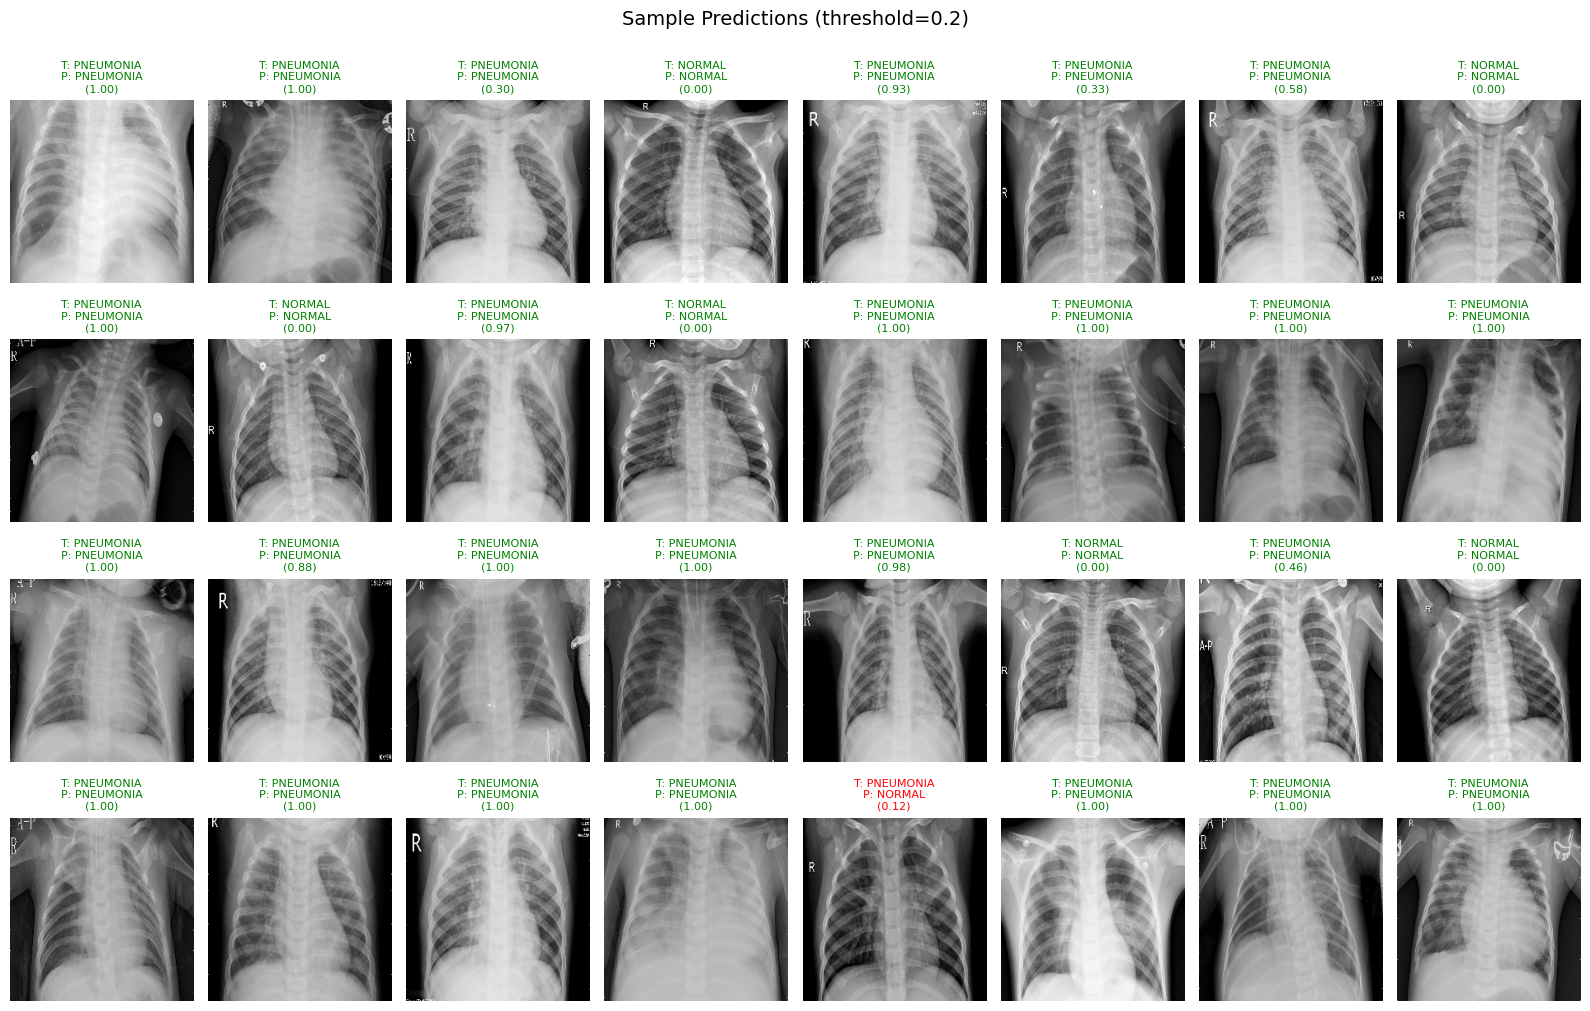

In [54]:
THRESHOLD = 0.2  # determined from the threshold tuning results

plt.figure(figsize=(16, 10.5))
for images, labels in Testing_dataset.skip(2).take(1):
    batch_images = images.numpy()
    true_labels  = labels.numpy()
    break

# ✅ prediction using the flatten() , and threshold
probs_batch = model.predict(images, verbose=0).flatten()
pred_labels = (probs_batch > THRESHOLD).astype(int)

for i in range(min(len(batch_images), 32)):
    plt.subplot(4, 8, i + 1)
    img = batch_images[i]
    img = (img - img.min()) / (img.max() - img.min())
    plt.imshow((img * 255).astype('uint8'))

    true_name = class_names[true_labels[i]]
    pred_name = class_names[pred_labels[i]]
    prob      = probs_batch[i]

    color = 'green' if true_labels[i] == pred_labels[i] else 'red'
    plt.title(f"T: {true_name}\nP: {pred_name}\n({prob:.2f})", fontsize=8, color=color)
    plt.axis('off')

plt.suptitle(f"Sample Predictions (threshold={THRESHOLD})\n", fontsize=14)
plt.tight_layout()
plt.show()

### 14. ROC Curve

In [29]:
fpr, tpr, _ = sk_metrics.roc_curve(all_labels, all_probs)
auc_score   = sk_metrics.roc_auc_score(all_labels, all_probs)

fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC (AUC={auc_score:.3f})', fill='tozeroy'))
fig.add_trace(go.Scatter(x=[0,1], y=[0,1], mode='lines', line=dict(dash='dash', color='gray'), name='Random'))
fig.update_layout(title='ROC Curve', xaxis_title='False Positive Rate', yaxis_title='True Positive Rate', height=450)
fig.show()